# **Version 5**
----
Image Captioning model with category prediction.

Model with image encoder and language encoder.

Image encoder is the features extracted from a pre-trained model, with additional convolutional layers. 

Language encoder is built using GRUs, Attention layers for the partial text of the caption.

The features are then merged to predict the next word in for the caption.

There are 12 categories of clothing. Excluding the jewellery category

#### Importing the necessary libraries.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle
import numpy as np
import os
import cv2
import string
from collections import Counter
from PIL import Image
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Add, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Concatenate, Flatten
from tensorflow.keras.layers import LSTM, Bidirectional, GRU
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50V2, VGG16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import backend as K
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras.layers import Layer
from tensorflow.keras.optimizers import Adam
import random
import json

In [ ]:
main_dir = '/content/drive/My Drive/ImageCaptioning/'

#### Creating the requirements.txt file

In [ ]:
!pip3 install pipreqsnb
!pipreqsnb --savepath 'requirements.txt' '/content/drive/My Drive/Colab Notebooks/ImageCaptioning_V5.ipynb'

  Created wheel for pipreqsnb: filename=pipreqsnb-0.2.3-cp36-none-any.whl size=4093 sha256=6726a44deadf5ce5753087273342c59fe478e1b5a8d0dc62f3bfbae54ce2e6e2
  Stored in directory: /root/.cache/pip/wheels/0b/7f/8c/398433fa8cd44f546c711f5314a1ee01f038bcfc771a2d3588
Successfully built pipreqsnb
pipreqs  --savepath requirements.txt .//__temp_pipreqsnb_folder/
INFO: Successfully saved requirements file in requirements.txt


#### Loading the annotations file, pre-processing it

In [ ]:
# loading the annotations file
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

# extract descriptions for images
def load_descriptions(doc):
    mapping = dict()
    cat_mapping = dict()
    for line in doc.split('\n'):
        tokens = line.strip().split('\t')
        if len(line) < 2:
            continue
        image_id, image_desc, image_cat = tokens[0], tokens[1], tokens[2]
        image_id = image_id.split('.')[0]
        image_desc = image_desc
        if image_id not in mapping:
            mapping[image_id] = image_desc
            cat_mapping[image_id] = image_cat
    return mapping, cat_mapping

def clean_descriptions(descriptions):
    table = str.maketrans('', '', string.punctuation)
    for key, desc in descriptions.items():
        desc = desc.split(' ')
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        desc = [word for word in desc if len(word)>1]
        descriptions[key] =  ' '.join(desc)

# save descriptions to file, one per line
def save_doc(descriptions, filename):
    lines = list()
    for key, desc in descriptions.items():
        lines.append(key + '\t' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

filename = main_dir + 'annotations_v5.txt'
doc = load_doc(filename)
print('Finished loading', filename)
descriptions, categories = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))
clean_descriptions(descriptions)
print("Finished cleaning descriptions")
all_tokens = ' '.join(descriptions.values()).split()
vocabulary = set(all_tokens)
print('Vocabulary Size: %d' % len(vocabulary))
unq_categories = set(categories.values())
print('Number of categories: %d' % len(unq_categories))
print("The unique categories are", unq_categories)
#save_doc(descriptions, main_dir+'descriptions_v2.txt')

Finished loading /content/drive/My Drive/ImageCaptioning/annotations_v5.txt
Loaded: 31041 
Finished cleaning descriptions
Vocabulary Size: 2247
Number of categories: 14
The unique categories are {"Women's Kurtas", "Men's Jeans", "Women's Sarees", "Men's Shirts", "Men's Shoes", "Men's Jackets", "Women's Shirts", "Women's Shoes", "Women's Dresses", "Women's Tops", "Women's T-Shirts", "Men's T-Shirts", "Women's Jeans", "Women's Jackets"}


#### Shuffling and splitting the data to training, validation and testing dataset.

In [ ]:
product_ids = list(descriptions.keys())
for i in range(10):
    random.shuffle(product_ids)
train_product_ids = product_ids[:int(0.9*len(product_ids))]
random.shuffle(train_product_ids)
val_product_ids = product_ids[int(0.9*len(product_ids)):int(0.95*len(product_ids))]
random.shuffle(val_product_ids)
test_product_ids = product_ids[int(0.95*len(product_ids)):]
random.shuffle(test_product_ids)
print(len(product_ids))
print(len(train_product_ids))
print(len(val_product_ids))
print(len(test_product_ids))

31041
27936
1552
1553


#### Pre-processing to find vocab_size and max_caption_length

In [ ]:
### PREPROCESSING CAPTIONS FOR TRAINING
def load_captions(descriptions,train_product_ids):
    train_captions=[]
    for image_id in descriptions.keys():
      if image_id in train_product_ids:
        train_captions.append('startseq '+descriptions[image_id]+' endseq')
    
    return train_captions

captions = load_captions(descriptions, product_ids)

In [ ]:
# WORD TO INDEX DICTIONARY

corpus = []
for caption in captions:
    for token in caption.split():
        corpus.append(token)
        
hash_map = Counter(corpus)
vocab = []
for token,count in hash_map.items():
        if count > 1:
            vocab.append(token)
        
print('Number of original tokens',len(hash_map))
print('Number of tokens after threshold',len(vocab))

word_to_index = {}
index_to_word = {}
    
for idx,token in enumerate(vocab):
    word_to_index[token] = idx+1
    index_to_word[idx+1] = token

vocab_size = len(index_to_word) + 1 # one for appended 0's

print(len(index_to_word))

## MAX LENGTH OF CAPTIONS

def max_len_caption(all_train_captions):   
    max_len = 0
    for caption in all_train_captions:
        max_len = max(max_len,len(caption.split()))
    print('Maximum length of caption= ',max_len)
    return max_len

max_length_caption = max_len_caption( captions )

Number of original tokens 2249
Number of tokens after threshold 2228
2228
Maximum length of caption=  16


#### Extracting the image folder

In [ ]:
## UNZIPPING IMAGES
from zipfile import ZipFile

filename= main_dir+'images_v5.zip'
print(filename)
zip = ZipFile(filename)
zip.extractall()

import os
print(len(os.listdir('/content/images_v5')))

/content/drive/My Drive/ImageCaptioning/images_v5.zip
31041


#### Extracting the image features and storing it in a dictionary

In [ ]:
#from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input

def load_img_features(product_ids):
	features=dict()
	product_ids_new = []
	model = ResNet50V2(include_top=False, pooling='max')
	image_dir ='/content/images_v5/'

	for j,id in enumerate(product_ids): 
		if j%100 == 0:
			print(j)
		try:
			image_name = image_dir+ id+'.jpg'
			image=  load_img(image_name,target_size=(299, 299,3))
			image = img_to_array(image)
			image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
			image = preprocess_input(image)
			feature = model.predict(image, verbose=0)
			product_ids_new.append(id)
			features[id] = feature.reshape(2,2,512)
		except OSError:
		  print("Error with file")
  
	print("Loaded", len(features.keys()) ,"number of features" )
	print(features[id].shape)
	print(type(features[id]))
	return features, product_ids_new


In [ ]:
print("Loading train data...")
train_features, train_product_ids = load_img_features(train_product_ids)
print("Finished loading train data!")

print("Loading validation data.....")
val_features, val_product_ids = load_img_features(val_product_ids)
print("Finished loading validation data")

Loading train data...
94674944/94668760 [==============================] - 1s 0us/step
0
Error with file
100
200
300
400
500
600
700
800
900
Error with file
1000
1100
1200
Error with file
1300
1400
1500
Error with file
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
Error with file
3400
3500
Error with file
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
Error with file
4700
4800
4900
5000
Error with file
5100
5200
5300
5400
5500
5600
5700
Error with file
5800
5900
6000
Error with file
6100
6200
Error with file
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
Error with file
8100
8200
8300
Error with file
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
Error with file
9500
9600
9700
9800
9900
Error with file
10000
10100
10200
10300
10400
Error with file
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
Error with file
12200
12300
12400
125

#### Loading the captions dictionary

Creating seperate dictionaries for different splits of data, along with the `<startseq>` and `<endseq>` token.

In [ ]:
def load_captions_dict(descriptions,train_product_ids):
    train_captions=dict()
    for image_id in descriptions.keys():
      if image_id in train_product_ids:
        train_captions[image_id]= 'startseq '+descriptions[image_id]+' endseq'
    
    return train_captions

In [ ]:
train_captions = load_captions_dict(descriptions,train_product_ids)
val_captions = load_captions_dict(descriptions, val_product_ids)

#### Pre-processing categories

In [ ]:
# PREPROCESSING CATEGORIES
import pandas as pd

encoded_data, mapping_index = pd.Series(list(unq_categories)).factorize()

def oneHotEncoding(x):
    ans = np.zeros((len(unq_categories)))
    ans[x] = 1
    return ans

def load_categories_dict(categories, train_product_ids):
	train_categories=dict()
	for image_id in categories.keys():
		if image_id in train_product_ids:
			x = mapping_index.get_loc(categories[image_id])
			train_categories[image_id] = oneHotEncoding(x)
	return train_categories

train_categories = load_categories_dict(categories, train_product_ids)
val_categories = load_categories_dict(categories, val_product_ids)
test_categories = load_categories_dict(categories, test_product_ids)

#### Defining the Attention Layer

In [ ]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
 
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
                #'supports_masking':self.supports_masking,
                #'init':self.init,
                'W_regularizer': self.W_regularizer,
                'b_regularizer': self.b_regularizer,
                'W_constraint': self.W_constraint,
                'b_constraint': self.b_constraint,
                'bias': self.bias,
                'step_dim':self.step_dim,
                #'features_dim':self.features_dim,
        })
        return config

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):

        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)
        a = K.exp(eij)
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

#### Defining the model

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, TimeDistributed

ImageInput =Input(shape=(2,2,512,))
ImageEncoder = Conv2D(512,(3,3),padding='same',activation='relu')(ImageInput)
ImageEncoder = MaxPooling2D((2,2))(ImageEncoder)
ImageEncoder = Conv2D(512,(3,3),padding='same',activation='relu')(ImageEncoder)
ImageEncoder = Conv2D(512,(1,1),padding='same',activation='relu')(ImageEncoder)
ImageEncoder = Flatten()(ImageEncoder)
ImageEncoder = Dropout(0.4)(ImageEncoder)
ImageEncoder = Dense(1024, activation='relu')(ImageEncoder)
ImageEncoder = Dense(256, activation='relu')(ImageEncoder)
Classifier = Dense(len(unq_categories), activation='softmax', name='classifier_output')(ImageEncoder)

# Language Encoder
LanguageEncoderInput = Input(shape=(max_length_caption,))
LanguageEncoder = Embedding(vocab_size, 128, mask_zero=True)(LanguageEncoderInput)
LanguageEncoder = Dropout(0.35)(LanguageEncoder)
LanguageEncoder = Bidirectional(GRU(128, return_sequences=True, dropout=0.25))(LanguageEncoder) 
LanguageEncoder = Bidirectional(GRU(128, return_sequences=True, dropout=0.25))(LanguageEncoder) 
LanguageEncoder = Attention(max_length_caption)(LanguageEncoder)

#Decoder
Decoder = Add()([ImageEncoder, LanguageEncoder])
Decoder = Reshape((1,256))(Decoder)
Decoder = Bidirectional(GRU(128, return_sequences=True,dropout=0.25))(Decoder) 
Decoder = Flatten()(Decoder)
Decoder = Dropout(0.4)(Decoder)
Decoder = Dense(1024, activation='relu')(Decoder)
Decoder = Dropout(0.4)(Decoder)
Decoder = Dense(500, activation='relu')(Decoder)

FinalDecoder = Dense(vocab_size, activation='softmax', name='decoder_output')(Decoder)
losses = {
	"classifier_output": "categorical_crossentropy",
	"decoder_output": "categorical_crossentropy",
}

lossWeights = { "classifier_output": 0.5, "decoder_output": 1.5 }

model = Model( inputs = [ImageInput, LanguageEncoderInput],
               outputs=[FinalDecoder, Classifier], name='Captioner')
model.compile(loss=losses, loss_weights = lossWeights, optimizer=Adam(lr=5e-5,decay=1e-5))
model.summary()

Model: "Captioner"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 2, 2, 512)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 2, 2, 512)    2359808     input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 1, 1, 512)    0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1, 1, 512)    2359808     max_pooling2d_6[0][0]            
__________________________________________________________________________________________

#### Plotting the model

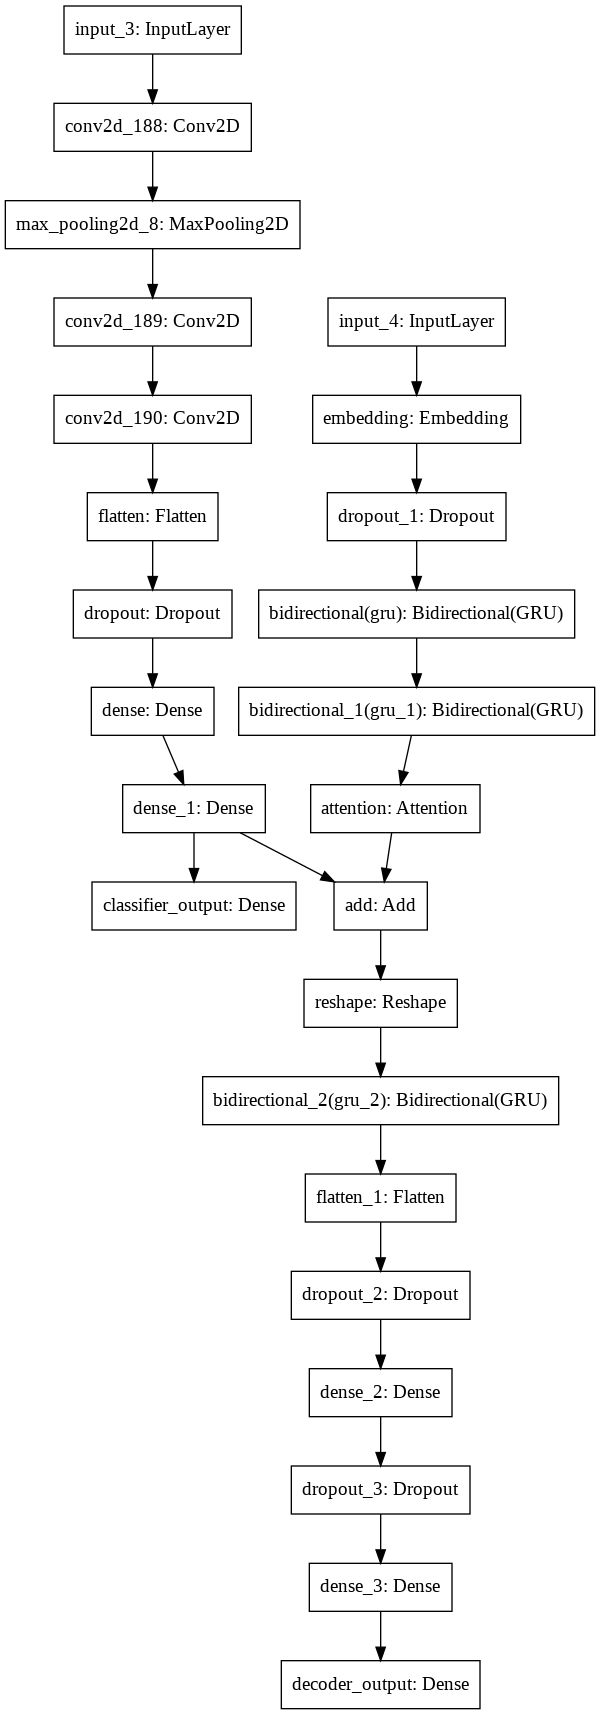

In [ ]:
from keras.utils import plot_model
plot_model(model)

#### Defining the custom data generator

In [ ]:
def data_generator(descriptions, wordtoix, photos, categories, max_length, num_photos_per_batch):

	image_dir ='/content/images_v5/'
	#in_layer = Input(shape=(224, 224, 3))

	X1, X2, y1, y2 = list(), list(), list(), list()
	n=0
	# loop for ever over images
	while 1:
		for key, desc in descriptions.items():
			n+=1
			# retrieve the photo feature
			temp=main_dir
			try:
				photo = photos[key]
			
				for abc in range(1):
						# encode the sequence
				
					seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
						
					# split one sequence into multiple X, y pairs
					for i in range(1, len(seq)):
						# split into input and output pair
						in_seq, out_seq = seq[:i], seq[i]
						# pad input sequence
						in_seq = pad_sequences([in_seq], maxlen=max_length, dtype='float64')[0]
						# encode output sequence
						out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
						# store
					
						X1.append(photo)
						X2.append(in_seq)
						y1.append(out_seq)
						y2.append(categories[key])
			except KeyError:
				continue

			# yield the batch data
			if n==num_photos_per_batch:
				yield ([np.array(X1, dtype='float64'),
							np.array(X2, dtype='float64')], {'decoder_output':np.array(y1, dtype='float64'),
															'classifier_output':np.array(y2, dtype='float64')})
				
				#X1, X2, y1, y2 = list(), list(), list(), list()
				X1, X2, y1, y2 = list(), list(), list(), list()
				n=0
			

#### Training the model

In [ ]:
epochs = 100
number_pics_per_batch = 64
output_dir = main_dir + 'model5/'
temp = main_dir

In [ ]:
generator = data_generator(train_captions,  word_to_index, train_features ,train_categories, max_length_caption, number_pics_per_batch)
val_generator = data_generator(val_captions, word_to_index, val_features, val_categories, max_length_caption, number_pics_per_batch)

In [ ]:
steps = len(train_captions)//number_pics_per_batch

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1,min_lr=1e-7, factor = 0.5)

if os.path.exists(output_dir) == False:
    os.mkdir(output_dir)
  
history = model.fit_generator(generator, validation_data = val_generator, 
                                    validation_steps = len(val_captions)//number_pics_per_batch
                                    ,epochs=epochs,
                                steps_per_epoch=steps,
                                verbose=1, 
                               callbacks=[reduce_lr])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
436/436 [==============================] - 190s 437ms/step - loss: 9.8798 - decoder_output_loss: 5.7426 - classifier_output_loss: 2.5319 - val_loss: 8.6336 - val_decoder_output_loss: 4.9379 - val_classifier_output_loss: 2.4535
Epoch 2/100
436/436 [==============================] - 106s 242ms/step - loss: 7.8442 - decoder_output_loss: 4.6481 - classifier_output_loss: 1.7440 - val_loss: 8.1161 - val_decoder_output_loss: 4.6400 - val_classifier_output_loss: 2.3122
Epoch 3/100
436/436 [==============================] - 101s 232ms/step - loss: 7.1353 - decoder_output_loss: 4.2858 - classifier_output_loss: 1.4132 - val_loss: 7.7680 - val_decoder_output_loss: 4.3972 - val_classifier_output_loss: 2.3443
Epoch 4/100
436/436 [==============================] - 98s 225ms/step - loss: 6.7284 - decoder_output_loss: 4.0033 - classifier_output_loss: 1.4468 - val_loss: 7.3239 - val_decoder_output_loss: 4.1757 - val_

#### Saving the model

In [ ]:
model.save(output_dir+'V5(3).h5')

#### Plotting the loss curves

dict_keys(['loss', 'decoder_output_loss', 'classifier_output_loss', 'val_loss', 'val_decoder_output_loss', 'val_classifier_output_loss', 'lr'])
loss


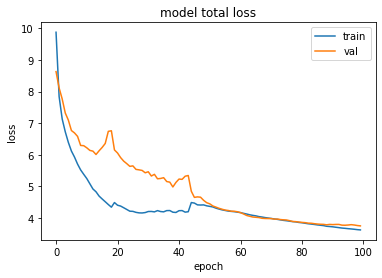

decoder_output_loss


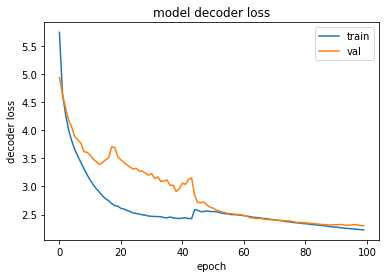

classifier_output_loss


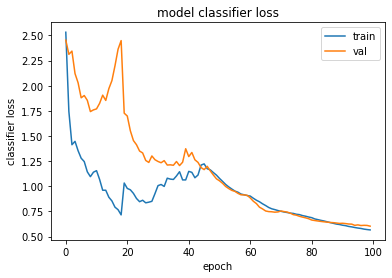

In [ ]:
import matplotlib.pyplot as plt
print(history.history.keys())
 
# summarize history for loss
print('loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model total loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()


print('decoder_output_loss')
plt.plot(history.history['decoder_output_loss'])
plt.plot(history.history['val_decoder_output_loss'])
plt.title('model decoder loss')
plt.ylabel('decoder loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()


print('classifier_output_loss')
plt.plot(history.history['classifier_output_loss'])
plt.plot(history.history['val_classifier_output_loss'])
plt.title('model classifier loss')
plt.ylabel('classifier loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

#### Saving the corresponding data in a **JSON** file for using it while loading the mdoel later.

In [ ]:
import pandas as pd

encoded_data, mapping_index = pd.Series(list(unq_categories)).factorize()
print(mapping_index)

Categories_mapping = list(mapping_index)
print(Categories_mapping)

f= open(output_dir+'V5(3).json','w')
data = {'word_to_index':word_to_index,
        'index_to_word':index_to_word,
        'categories_mapping':Categories_mapping,
        'max_length_caption':max_length_caption}
json.dump(data,f)
f.close()

Index(['Women's Kurtas', 'Men's Jeans', 'Women's Sarees', 'Men's Shirts',
       'Men's Shoes', 'Men's Jackets', 'Women's Shirts', 'Women's Shoes',
       'Women's Dresses', 'Women's Tops', 'Women's T-Shirts', 'Men's T-Shirts',
       'Women's Jeans', 'Women's Jackets'],
      dtype='object')
["Women's Kurtas", "Men's Jeans", "Women's Sarees", "Men's Shirts", "Men's Shoes", "Men's Jackets", "Women's Shirts", "Women's Shoes", "Women's Dresses", "Women's Tops", "Women's T-Shirts", "Men's T-Shirts", "Women's Jeans", "Women's Jackets"]


#### Loading the saved model.

In [ ]:
from tensorflow.keras.models import load_model
output_dir = main_dir + 'model5/'

from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras.initializers import glorot_uniform

with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
    model = load_model(output_dir+'V5(1).h5', custom_objects={'Attention':Attention})

In [ ]:
f = open(output_dir + 'V5(3).json','r')
data = json.load(f)
index_to_word = data['index_to_word']
word_to_index = data['word_to_index']
categories_mapping = data['categories_mapping']

max_length_caption = int(data['max_length_caption'])
f.close()

#### Loading the test data

In [ ]:
test_features, test_product_ids = load_img_features(test_product_ids)
test_captions = load_captions_dict(descriptions, test_product_ids)

0
Error with file
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
Loaded 1552 number of features
(2, 2, 512)
<class 'numpy.ndarray'>


#### Testing the model

##### Testing the model without beam search

In [ ]:
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

def greedySearch(photo):
    final = 'startseq'

    for i in range(max_length_caption):
        sequence = [word_to_index[w] for w in final.split(' ') if w in word_to_index]
        sequence = pad_sequences([sequence], maxlen = max_length_caption)
        yhat = model.predict([photo,sequence],verbose=1)
        seq_yhat, cls_yhat = yhat
        seq_yhat = str(np.argmax(seq_yhat[0], axis=0))
        cls_yhat+=cls_yhat
           
        word = index_to_word[seq_yhat]
        final +=' '+word
        if word == 'endseq':
            break
    cls_yhat = cls_yhat / (i+1)
    cls_yhat = np.argmax(cls_yhat)
    print(categories_mapping[cls_yhat])
    final = final.split()
    final = final[1:-1]
    final = ' '.join(final)
    
    return final

test_samples = 30
for i in range(test_samples):
        pic= test_product_ids[i]
        print(pic)
        image = test_features[pic].reshape(1,2,2,512)
        cv2_imshow(cv2.imread('/content/images_v5/'+pic+'.jpg'))

        result = greedySearch(image)

        print("Actual output:",test_captions[pic])
        print("Predicted output:",result)